# ASSIGNMENT 2: MovieLens Dataset.

The dataset describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. In this project we use standard (latest) version of the MovieLens dataset. As in the previous assignmnet we will analyzie and explore the data, then we will pre-process the data and build a rule based and clustering based recommender system. Our steps:

1. Analyzing and Exploring the data.
2. Pre-processing.
3. Clustering.
4. Rule based system.
5. Accuracy.


### 01. Analyzing and Exploring the data - movie lens dataset.

##### 🧾 **step 1: information about number of movies and number of users**


In [1]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
from scipy.sparse import csr_matrix
import recommendation as rec
from sklearn.neighbors import NearestNeighbors
from mlxtend.frequent_patterns import apriori
from sklearn.cluster import KMeans
import math
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [8]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610


##### 📽️ **step 2: distribution of movie ratings**

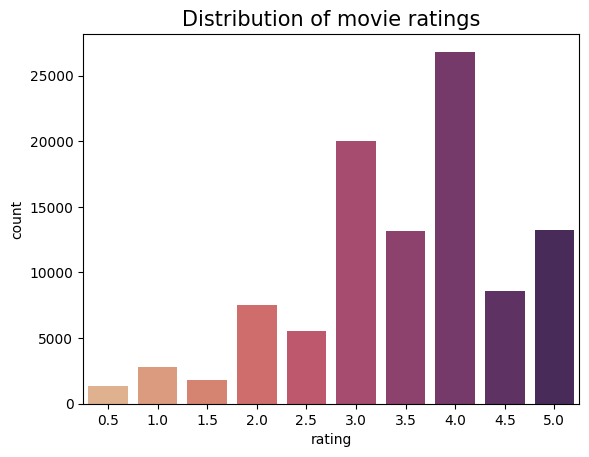

In [10]:
sns.countplot(x="rating", data = ratings, palette = "flare", hue="rating",legend=False)
plt.title("Distribution of movie ratings", fontsize = 15)
plt.show()

##### 📈 **step 3: most frequently rated movies**

In [11]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [12]:
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

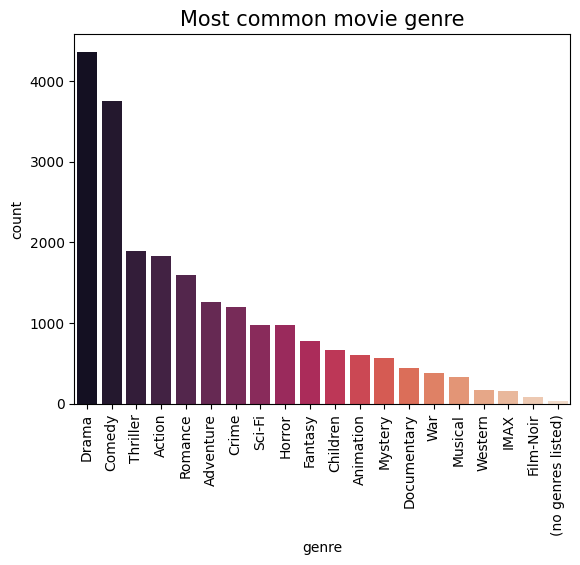

In [13]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', hue= "genre", data=genre_frequency_df.sort_values(by='count', ascending=False), palette="rocket")
plt.xticks(rotation=90)
plt.title("Most common movie genre", fontsize = 15)
plt.show()

### 02. Data Pre-processing.

We want to use apriori algorithm and clustering methods to improve our recomendation system. Before that - there is a need to clean the dataset and prepare new datasets.

##### 🧹 **step 1: cleaning dataset:** 
- _genres_ was expressed as a string with a pipe | separating each genre. We wanted to delete this pipe - we created a list instead.
- _title_ we cannot extract year of the movie from the title, because some names of the movie repeat.

- divide genres into zero's and one's if given movie has a label of given genre

In [14]:
unique_genres = set(g for genres in movies['genres'] for g in genres)

for genre in unique_genres:
    movies[genre] = movies.genres.transform(lambda x: int(genre in x))

- _timestamp_ to delete, because it  won't help with recommendation system

In [15]:
del ratings['timestamp']

In [16]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


- _genres_ to delete, because we change the movie table

In [17]:
del movies['genres']

In [18]:
movies.head()

,movieId,title,IMAX,Action,Crime,Comedy,Children,Drama,Fantasy,War,...,Musical,Mystery,Horror,Film-Noir,Romance,Sci-Fi,Adventure,Western,Animation,Documentary
0,1,Toy Story (1995),0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,2,Jumanji (1995),0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- movie_kmeans used in KMeans method

In [19]:
movies_kmeans = movies.drop(columns = ['title'])

In [20]:
movies_kmeans.head()

,movieId,IMAX,Action,Crime,Comedy,Children,Drama,Fantasy,War,(no genres listed),...,Musical,Mystery,Horror,Film-Noir,Romance,Sci-Fi,Adventure,Western,Animation,Documentary
0,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 🍀 **step 2: shrinking the dataset**

📌 **note:** our datset is too big to hande - there are many methods to deal with that problem. We chose:
- **data shrinking: by choosing the users who like maximum number of movies**
- **our hypothesis:** we assume that users who rate the movies most often are the most important ones in recomendation system, that's why we take 2000 best of them


➕ top 10 visualization: {only visualization for raport}

In [21]:
top_10 = rec.shrinking_data(10, ratings)
top_10

,userId,movieId,rating
0,68,1,2.5
1,68,2,2.5
2,68,3,2.0
3,68,5,2.0
4,68,6,4.0
...,...,...,...
16439,610,166534,4.0
16440,610,168248,5.0
16441,610,168250,5.0
16442,610,168252,5.0


In [22]:
top_10_final = top_10.groupby('userId')['movieId'].count()
top_10_final

userId
68     1260
274    1346
288    1055
380    1218
414    2698
448    1864
474    2108
599    2478
606    1115
610    1302
Name: movieId, dtype: int64

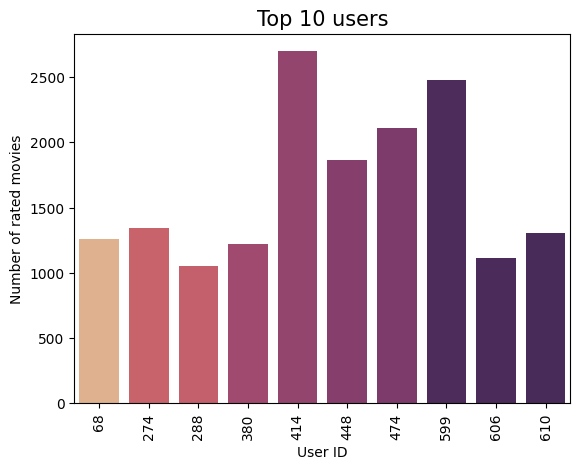

In [23]:
top_10_final_df = top_10_final.reset_index()
top_10_final_df.columns = ['userId', 'count']

sns.barplot(x='userId', y='count', hue='userId', 
            data=top_10_final_df.sort_values(by='count', ascending=False), 
            palette="flare", legend=False)

plt.xticks(rotation=90)
plt.title("Top 10 users", fontsize=15)
plt.xlabel('User ID')
plt.ylabel('Number of rated movies')
plt.show()

➕ important shrinking

In [24]:
shrinked_ratings = rec.shrinking_data(2000, ratings)

In [25]:
shrinked_ratings.shape

(100836, 3)

In [26]:
shrinked_ratings[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


##### 🚀 **step 2: merging the dataset**

In [27]:
movie_data = shrinked_ratings.merge(movies, on='movieId')

In [28]:
movie_data.head()

,userId,movieId,rating,title,IMAX,Action,Crime,Comedy,Children,Drama,...,Musical,Mystery,Horror,Film-Noir,Romance,Sci-Fi,Adventure,Western,Animation,Documentary
0,1,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
1,5,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
2,7,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
3,15,1,2.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
4,17,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0


In [29]:
movie_data.shape

(100836, 24)

In [30]:
movie_data['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

##### 🎯 **step 3: splitting the raitings dataset** 
- we use **cross validation** which is technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data to use it in Kmeans (clustering) later on
- **KFold** explanation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- after cross validation we use combine_datasets() method to combine all train sets and test sets in two separate dataframes

**step 3.1 : KFold split - cross validation**

In [31]:
kf = KFold(n_splits = 5, shuffle = True, random_state=42)

In [32]:
train_df, test_df = rec.return_datasets(movie_data, kf)

In [33]:
for i in range(len(train_df)):
    print(f"Fold {i+1}")
    print("Train Data:")
    print(train_df[i].head())
    print(train_df[i].shape)
    print("Test Data:")
    print(test_df[i].head())
    print(test_df[i].shape)
    print("\n")

Fold 1
Train Data:
   userId  movieId  rating             title  IMAX  Action  Crime  Comedy  \
0       1        1     4.0  Toy Story (1995)     0       0      0       1   
1       5        1     4.0  Toy Story (1995)     0       0      0       1   
2       7        1     4.5  Toy Story (1995)     0       0      0       1   
3      15        1     2.5  Toy Story (1995)     0       0      0       1   
4      17        1     4.5  Toy Story (1995)     0       0      0       1   

   Children  Drama  ...  Musical  Mystery  Horror  Film-Noir  Romance  Sci-Fi  \
0         1      0  ...        0        0       0          0        0       0   
1         1      0  ...        0        0       0          0        0       0   
2         1      0  ...        0        0       0          0        0       0   
3         1      0  ...        0        0       0          0        0       0   
4         1      0  ...        0        0       0          0        0       0   

   Adventure  Western  Animatio

### 03. Clustering based recommender system.

Movie recommendations system based on K-means. 

##### 🌺 **step 1: calculating how many k is needed**

Let's plot the graph using **elbow method** - graphical method for finding the optimal K value in a k-means clustering algorithm. The elbow graph shows the within-cluster-sum-of-square (WCSS) values on the y-axis corresponding to the different values of K.

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 0 0 ... 4 4 4]


c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

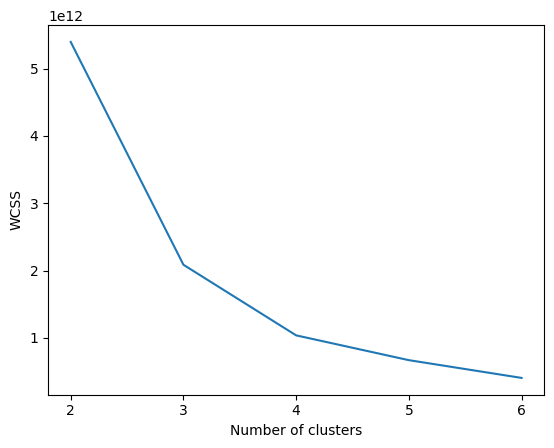

In [34]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_tabels = kmeans.fit_predict(movies_kmeans)

print(cluster_tabels)

wcss = []
max_clusters = 6

for num_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(movies_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters+1), wcss)
plt.xticks([2,3,4,5,6])
plt.xlabel("Number of clusters")
plt.ylabel('WCSS')
plt.show()

📌 **note:** k = 5

In [35]:
n_clusters=5

##### 🌸 **step 2: provide k-means**

In [36]:
mse_list, models, train_dfs = rec.train_kmeans_and_predict(train_df, test_df, n_clusters=4)

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

##### 🔮 **step 3: predict for given userId and movieId**

In [37]:
userId = 145
movieId = 123

In [38]:
predicted_rating, predicted_cluster, cluster_mean_ratings = rec.predict_rating_kmeans(userId, movieId, models, train_dfs, movie_data)
predicted_rating = rec.roundRating(predicted_rating)
print(f'Predicted rating for user {userId} and movie {movieId}: {round(predicted_rating,2)}')

Predicted rating for user 145 and movie 123: 3.5


### 04. Rule based recommender system.

##### 🔥 **step 1: apriori algorithm**

Having already generated clusters, we can use the apriori algorithm to generate rules for each cluster.

In [39]:
#example of generated train dataset after kfold
train_dfs[0].head()

,userId,movieId,rating,title,IMAX,Action,Crime,Comedy,Children,Drama,...,Mystery,Horror,Film-Noir,Romance,Sci-Fi,Adventure,Western,Animation,Documentary,cluster
0,1,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,2
1,5,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,2
2,7,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,2
3,15,1,2.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,2
4,17,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,2


In [40]:
freq_item = rec.getFrequentItemset(train_dfs)

c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\lidka\AppData\Local\Programs\Python\Pyth

In [41]:
freq_item[0][3]

,support,itemsets
0,0.118727,(IMAX)
1,0.855956,(Action)
2,0.058381,(Crime)
3,0.156113,(Comedy)
4,0.098293,(Children)
...,...,...
89,0.044235,"(IMAX, Adventure, Sci-Fi, Action)"
90,0.020939,"(Children, Adventure, Action, Comedy)"
91,0.035983,"(Fantasy, Adventure, Action, Comedy)"
92,0.024587,"(Romance, Adventure, Action, Comedy)"


##### 🔥 **step 2: association rules**

In [42]:
rules = rec.getRules(freq_item)

In [43]:
rules[0][2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(IMAX),(Drama),0.029717,0.864350,0.028384,0.955150,1.105050,0.002698,3.024495,0.097975
1,(Action),(Drama),0.103761,0.864350,0.103761,1.000000,1.156939,0.014075,inf,0.151355
2,(Crime),(Drama),0.140932,0.864350,0.134762,0.956217,1.106285,0.012947,3.098249,0.111835
3,(Children),(Drama),0.071231,0.864350,0.060026,0.842689,0.974939,-0.001543,0.862304,-0.026931
4,(Fantasy),(Drama),0.050696,0.864350,0.043686,0.861733,0.996973,-0.000133,0.981075,-0.003188
5,(War),(Drama),0.109883,0.864350,0.107266,0.976190,1.129393,0.012289,5.697305,0.128712
6,(Romance),(Drama),0.203722,0.864350,0.194442,0.954446,1.104236,0.018355,2.977809,0.118547
7,(Adventure),(Drama),0.091322,0.864350,0.091322,1.000000,1.156939,0.012388,inf,0.149283
8,"(War, Action)",(Drama),0.047191,0.864350,0.047191,1.000000,1.156939,0.006401,inf,0.142369
9,"(Children, Adventure)",(Drama),0.023793,0.864350,0.023793,1.000000,1.156939,0.003228,inf,0.138956


##### 🔥 **step 3: predicting the rating**

In [44]:
userId = 145
movieId = 23
predicted_rating, predicted_cluster, cluster_mean_ratings = rec.predict_rating_kmeans(userId, movieId, models, train_dfs, movie_data)

In [45]:
im_ru = rec.filterRules(userId, movieId, movie_data, int(predicted_cluster[0]), cluster_mean_ratings, rules)
im_ru

c:\Users\lidka\OneDrive - put.poznan.pl\Pulpit\studia\4 semestr\DM\The Miners - assignment 2\DM-recomendation-system\recommendation.py:314: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rule[1]['antecedents'].issubset(movie[1][1]):
c:\Users\lidka\OneDrive - put.poznan.pl\Pulpit\studia\4 semestr\DM\The Miners - assignment 2\DM-recomendation-system\recommendation.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  important_rules.append((rule[1], movie[1][0]))


[(antecedents             (Action)
  consequents           (Thriller)
  antecedent support      0.349523
  consequent support      0.997385
  support                 0.348542
  confidence              0.997195
  lift                    0.999809
  leverage               -0.000067
  conviction              0.932061
  zhangs_metric          -0.000294
  Name: 0, dtype: object,
  2.0),
 (antecedents             (Action)
  consequents           (Thriller)
  antecedent support      0.349523
  consequent support      0.997385
  support                 0.348542
  confidence              0.997195
  lift                    0.999809
  leverage               -0.000067
  conviction              0.932061
  zhangs_metric          -0.000294
  Name: 0, dtype: object,
  3.0),
 (antecedents             (Action)
  consequents           (Thriller)
  antecedent support      0.349523
  consequent support      0.997385
  support                 0.348542
  confidence              0.997195
  lift                

In [46]:
rating = rec.predictRatingRules(im_ru)
rating = rec.roundRating(rating)
rating

3.5

### 05. Accuracy.

- we can use mean square error if we normalize and then denormalize the data
- if not: absolute error

##### **mean-squared error for rule based recommendation system**

In [47]:
## TODO LIDKA

##### **mean-squared error for clustering recommendation system**

In [48]:
mean_mse = sum(mse_list) / len(mse_list)
print(f'Mean Squared Error: {mean_mse}')

Mean Squared Error: 1.070554282572738


##### **mean-squared error in general**

In [49]:
## TODO

##### **Summary:** mean squared error for clustering recomendation system is equal to 1.05. We can rate movies from 0.5 to 5.0, then mse is value we can expect.